In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    scaler = StandardScaler()

    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y) ("hysteresis")
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    X_train = scaler.fit_transform(X_train.values)
    X_val = scaler.transform(X_val.values)
    X_test = scaler.transform(X_test.values)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Valores previstos')
    plt.ylabel('valores Reais')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt

In [5]:
class tenNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(tenNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.fc6 = nn.Linear(32, 32)
        self.fc7 = nn.Linear(32, 32)
        self.fc8 = nn.Linear(32, 32)
        self.fc9 = nn.Linear(32, 16)
        self.fc10 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))
        x = self.fc10(x)
        return x

In [6]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [7]:
from torch import tensor
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau



def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)

def train(model,num_epochs,optimizer,train_set,target):
  criterion = nn.MSELoss()
  scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
  for epoch in range(num_epochs):
      optimizer.zero_grad()
      outputs = model(train_set)
      loss = criterion(outputs, target)
      loss.backward()
      optimizer.step()
      if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate(model,val_set,val_target):
    criterion = nn.MSELoss()
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_outputs = model(val_set)
        val_loss = criterion(val_outputs, val_target)
        print(f'Val_Loss: {val_loss}')


def test(model,data):
  model.eval()
  criterion_MSE = nn.MSELoss()
  criterion_MAE = nn.L1Loss()
  criterion_MAPE = MeanAbsolutePercentageError()
  with torch.no_grad():
      predicted = model(data[0])
      test_loss_MSE = criterion_MSE(predicted, data[1])
      test_loss_MAE = criterion_MAE(predicted, data[1])
      test_loss_MAPE = criterion_MAPE(predicted, data[1])
      print(f'MSE Test Loss: {test_loss_MSE.item():.4f}')
      print(f'MAE Test Loss: {test_loss_MAE.item():.4f}')
      print(f'MAPE Test Loss: {test_loss_MAPE.item():.4f}')
  return predicted

In [8]:
def train_kfold(model, num_epochs, optimizer, train_set, target, val_set, val_target):
    criterion = nn.MSELoss()

    numpy_train_set = train_set.numpy()
    numpy_target = target.numpy()
    numpy_val_set = val_set.numpy()
    numpy_val_target = val_target.numpy()

    for train_index, val_index in kf.split(train_set):
        # Split data into training and validation sets based on the fold indices
        X_train, X_val = numpy_train_set[train_index], numpy_train_set[val_index]
        y_train, y_val = numpy_target[train_index], numpy_target[val_index]

        X_train = torch.from_numpy(X_train)
        X_val = torch.from_numpy(X_val)
        y_train = torch.from_numpy(y_train)
        y_val = torch.from_numpy(y_val)
        # Train the model on the training fold
        # ... (rest of your training loop using X_train and y_train)
        train(model,num_epochs,optimizer,X_train,y_train)

        # Evaluate on the validation fold
        # ... (use X_val and y_val for validation)
        evaluate(model,X_val,y_val)
        # Reset optimizer for each fold (optional)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Example


In [9]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/V'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')


Separando os "targets"

In [10]:
histeresis_train_tensor = [pair[0].item() for pair in y_train_tensor]
histeresis_train_tensor = torch.tensor(histeresis_train_tensor, dtype=torch.float32)
histeresis_train_tensor = histeresis_train_tensor.unsqueeze(1)

joule_train_tensor = [pair[1].item() for pair in y_train_tensor]
joule_train_tensor = torch.tensor(joule_train_tensor, dtype=torch.float32)
joule_train_tensor = joule_train_tensor.unsqueeze(1)

histeresis_val_tensor = [pair[0].item() for pair in y_val_tensor]
histeresis_val_tensor = torch.tensor(histeresis_val_tensor, dtype=torch.float32)
histeresis_val_tensor = histeresis_val_tensor.unsqueeze(1)

joule_val_tensor = [pair[1].item() for pair in y_val_tensor]
joule_val_tensor = torch.tensor(joule_val_tensor, dtype=torch.float32)
joule_val_tensor = joule_val_tensor.unsqueeze(1)

histeresis_test_tensor = [pair[0].item() for pair in y_test_tensor]
histeresis_test_tensor = torch.tensor(histeresis_test_tensor, dtype=torch.float32)
histeresis_test_tensor = histeresis_test_tensor.unsqueeze(1)

joule_test_tensor = [pair[1].item() for pair in y_test_tensor]
joule_test_tensor = torch.tensor(joule_test_tensor, dtype=torch.float32)
joule_test_tensor = joule_test_tensor.unsqueeze(1)

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

criando modelos para teste


In [12]:
input_size = X_train_tensor.shape[1]
print(input_size)

modelV_hysteresis = tenNetwork(input_size, 1)
modelV_joule = tenNetwork(input_size, 1)
modelV_total = tenNetwork(input_size, 2)

optimizer_h = optim.Adam(modelV_hysteresis.parameters(), lr=0.01)
optimizer_j = optim.Adam(modelV_joule.parameters(), lr=0.01)
optimizer_t = optim.Adam(modelV_total.parameters(), lr=0.01)

6


Testes para "histeresis"

In [13]:
train_kfold(modelV_hysteresis,2500,optimizer_h,X_train_tensor, histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)

Epoch [100/2500], Loss: 0.0224
Epoch [200/2500], Loss: 0.0174
Epoch [300/2500], Loss: 0.0168
Epoch [400/2500], Loss: 0.0164
Epoch [500/2500], Loss: 0.0175
Epoch [600/2500], Loss: 0.0163
Epoch [700/2500], Loss: 0.0172
Epoch [800/2500], Loss: 0.0230
Epoch [900/2500], Loss: 0.0158
Epoch [1000/2500], Loss: 0.0162
Epoch [1100/2500], Loss: 0.0184
Epoch [1200/2500], Loss: 0.0147
Epoch [1300/2500], Loss: 0.0171
Epoch [1400/2500], Loss: 0.0151
Epoch [1500/2500], Loss: 0.0149
Epoch [1600/2500], Loss: 0.0147
Epoch [1700/2500], Loss: 0.0150
Epoch [1800/2500], Loss: 0.0160
Epoch [1900/2500], Loss: 0.0148
Epoch [2000/2500], Loss: 0.0154
Epoch [2100/2500], Loss: 0.0153
Epoch [2200/2500], Loss: 0.0149
Epoch [2300/2500], Loss: 0.0132
Epoch [2400/2500], Loss: 0.0126
Epoch [2500/2500], Loss: 0.0144
Val_Loss: 0.022586127743124962
Epoch [100/2500], Loss: 0.0182
Epoch [200/2500], Loss: 0.0168
Epoch [300/2500], Loss: 0.0161
Epoch [400/2500], Loss: 0.0157
Epoch [500/2500], Loss: 0.0153
Epoch [600/2500], Loss:

In [14]:
train_kfold(modelV_joule,2500,optimizer_j,X_train_tensor, joule_train_tensor,X_val_tensor,joule_val_tensor)

Epoch [100/2500], Loss: 0.0278
Epoch [200/2500], Loss: 0.0261
Epoch [300/2500], Loss: 0.0247
Epoch [400/2500], Loss: 0.0241
Epoch [500/2500], Loss: 0.0235
Epoch [600/2500], Loss: 0.0233
Epoch [700/2500], Loss: 0.0231
Epoch [800/2500], Loss: 0.0239
Epoch [900/2500], Loss: 0.0230
Epoch [1000/2500], Loss: 0.0220
Epoch [1100/2500], Loss: 0.0217
Epoch [1200/2500], Loss: 0.0221
Epoch [1300/2500], Loss: 0.0223
Epoch [1400/2500], Loss: 0.0214
Epoch [1500/2500], Loss: 0.0205
Epoch [1600/2500], Loss: 0.0215
Epoch [1700/2500], Loss: 0.0213
Epoch [1800/2500], Loss: 0.0195
Epoch [1900/2500], Loss: 0.0194
Epoch [2000/2500], Loss: 0.0190
Epoch [2100/2500], Loss: 0.0204
Epoch [2200/2500], Loss: 0.0203
Epoch [2300/2500], Loss: 0.0181
Epoch [2400/2500], Loss: 0.0189
Epoch [2500/2500], Loss: 0.0170
Val_Loss: 0.033170249313116074
Epoch [100/2500], Loss: 0.0243
Epoch [200/2500], Loss: 0.0228
Epoch [300/2500], Loss: 0.0221
Epoch [400/2500], Loss: 0.0214
Epoch [500/2500], Loss: 0.0205
Epoch [600/2500], Loss:

In [15]:
train_kfold(modelV_total,2500,optimizer_t,X_train_tensor, y_train_tensor,X_val_tensor,y_val_tensor)

Epoch [100/2500], Loss: 0.0588
Epoch [200/2500], Loss: 0.0275
Epoch [300/2500], Loss: 0.0226
Epoch [400/2500], Loss: 0.0307
Epoch [500/2500], Loss: 0.0212
Epoch [600/2500], Loss: 0.0240
Epoch [700/2500], Loss: 0.0214
Epoch [800/2500], Loss: 0.0208
Epoch [900/2500], Loss: 0.0207
Epoch [1000/2500], Loss: 0.0217
Epoch [1100/2500], Loss: 0.0201
Epoch [1200/2500], Loss: 0.0206
Epoch [1300/2500], Loss: 0.0210
Epoch [1400/2500], Loss: 0.0251
Epoch [1500/2500], Loss: 0.0191
Epoch [1600/2500], Loss: 0.0217
Epoch [1700/2500], Loss: 0.0194
Epoch [1800/2500], Loss: 0.0186
Epoch [1900/2500], Loss: 0.0194
Epoch [2000/2500], Loss: 0.0185
Epoch [2100/2500], Loss: 0.0183
Epoch [2200/2500], Loss: 0.0191
Epoch [2300/2500], Loss: 0.0180
Epoch [2400/2500], Loss: 0.0207
Epoch [2500/2500], Loss: 0.0194
Val_Loss: 0.02630520798265934
Epoch [100/2500], Loss: 0.0308
Epoch [200/2500], Loss: 0.0207
Epoch [300/2500], Loss: 0.0198
Epoch [400/2500], Loss: 0.0194
Epoch [500/2500], Loss: 0.0206
Epoch [600/2500], Loss: 

In [16]:
previstos_h = test(modelV_hysteresis,[X_test_tensor,histeresis_test_tensor])

MSE Test Loss: 0.0273
MAE Test Loss: 0.0960
MAPE Test Loss: 0.8205


In [17]:
previstos_j = test(modelV_joule,[X_test_tensor,joule_test_tensor])

MSE Test Loss: 0.0464
MAE Test Loss: 0.1069
MAPE Test Loss: 1.1526


In [18]:
previstos_t = test(modelV_total,[X_test_tensor,y_test_tensor])

MSE Test Loss: 0.0340
MAE Test Loss: 0.1019
MAPE Test Loss: 0.8119


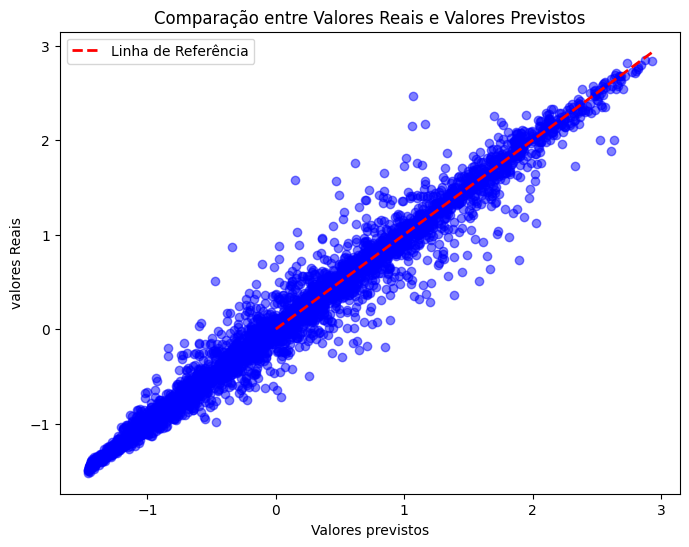

In [19]:
plot_comparacao(histeresis_test_tensor,previstos_h)

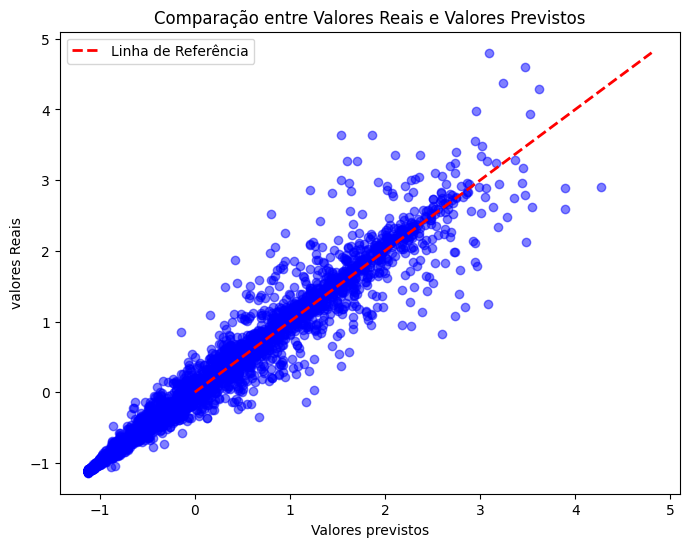

In [20]:
plot_comparacao(joule_test_tensor,previstos_j)

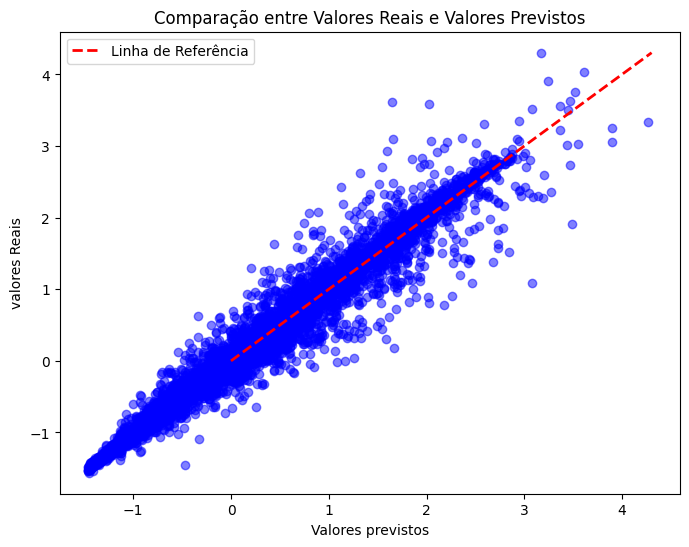

In [21]:
plot_comparacao(y_test_tensor,previstos_t)

In [22]:
mse_h = mean_squared_error(histeresis_test_tensor, previstos_h)
mae_h = mean_absolute_error(histeresis_test_tensor, previstos_h)
histeresis_test_np = histeresis_test_tensor.numpy()
previstos_np_h = previstos_h.numpy()
mape_h = np.mean(np.abs((histeresis_test_np - previstos_np_h) / histeresis_test_np)) * 100

mse_j = mean_squared_error(joule_test_tensor, previstos_j)
mae_j = mean_absolute_error(joule_test_tensor, previstos_j)
joule_test_np = joule_test_tensor.numpy()
previstos_np_j = previstos_j.numpy()
mape_j = np.mean(np.abs((joule_test_np - previstos_np_j) / joule_test_np)) * 100

mse_t = mean_squared_error(y_test_tensor, previstos_t)
mae_t = mean_absolute_error(y_test_tensor, previstos_t)
total_test_np = y_test_tensor.numpy()
previstos_np_t = previstos_t.numpy()
mape_t = np.mean(np.abs((total_test_np - previstos_np_t) / total_test_np)) * 100

print(f'V histeresis model:')
print(f'Test MSE: {mse_h}')
print(f'Test MAE: {mae_h}')
print(f'Test MAPE: {mape_h}%')

print(f'V joule model:')
print(f'Test MSE: {mse_j}')
print(f'Test MAE: {mae_j}')
print(f'Test MAPE: {mape_j}%')

print(f'V total model:')
print(f'Test MSE: {mse_t}')
print(f'Test MAE: {mae_t}')
print(f'Test MAPE: {mape_t}%')

V histeresis model:
Test MSE: 0.027314266189932823
Test MAE: 0.0959593653678894
Test MAPE: 82.04535245895386%
V joule model:
Test MSE: 0.04643004387617111
Test MAE: 0.10690949112176895
Test MAPE: 115.26288986206055%
V total model:
Test MSE: 0.03403119742870331
Test MAE: 0.1018797755241394
Test MAPE: 81.19302988052368%
